In [1]:
import os, json
from dataclasses import dataclass
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score)
from sklearn.model_selection import StratifiedKFold, train_test_split

import matplotlib
matplotlib.use("Agg") # You don't need this 
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

In [2]:
@dataclass
class DataConfig:
    csv_path: Optional[str] = None
    target_col: str = "diagnosis"
    test_size: float = 0.2
    val_size: float = 0.15  
    random_state: int = SEED
    drop_cols: Optional[List[str]] = None  
    sep: str = ","
    encoding: str = "utf-8"

@dataclass
class TrainConfig:
    n_trials: int = 50
    n_splits: int = 5
    early_stopping_rounds: int = 50
    auto_class_weights: Optional[str] = None  
    enable_feature_importances: bool = True


In [3]:
def _load_dataframe_or_sklearn_fallback(cfg: DataConfig) -> pd.DataFrame:
    if cfg.csv_path:
        if os.path.exists(cfg.csv_path):
            print(f"[INFO] Loading CSV from: {cfg.csv_path} (sep='{cfg.sep}', encoding='{cfg.encoding}')")
            df = pd.read_csv(cfg.csv_path, sep=cfg.sep, encoding=cfg.encoding)
            return df
        else:
            print(f"[WARN] CSV path not found: {cfg.csv_path}")
    print("[WARN] CSV not provided or not found. Falling back to sklearn breast_cancer dataset.")
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    df = ds.frame.copy()
    df.rename(columns={"target": cfg.target_col}, inplace=True)
    return df


def _detect_cat_features(X: pd.DataFrame) -> List[int]:
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    return [X.columns.get_loc(c) for c in cat_cols]


def _map_target_if_needed(y: pd.Series) -> pd.Series:
    if y.dtype == "O" or y.dtype.name == "category":
        uniques = sorted(list(y.dropna().unique()))
        if set(uniques) <= set(["M", "B"]):
            # M=1, B=0
            return y.map({"M": 1, "B": 0}).astype(int)
        if len(uniques) == 2:
            mapping = {uniques[0]: 0, uniques[1]: 1}
            print(f"[INFO] Mapping target labels: {mapping}")
            return y.map(mapping).astype(int)
    return y


def prepare_xy(df: pd.DataFrame, cfg: DataConfig) -> Tuple[pd.DataFrame, pd.Series]:
    df = df.copy()
    if cfg.drop_cols:
        for c in cfg.drop_cols:
            if c in df.columns:
                df.drop(columns=[c], inplace=True)

    if cfg.target_col not in df.columns:
        raise ValueError(f"Target column '{cfg.target_col}' not found in dataframe.")

    y = df[cfg.target_col]
    X = df.drop(columns=[cfg.target_col])

    for col in list(X.columns):
        if col.lower() in {"id", "unnamed: 32"}:
            X.drop(columns=[col], inplace=True, errors="ignore")

    y = _map_target_if_needed(y)

    for col in X.columns:
        if pd.api.types.is_numeric_dtype(X[col]):
            if X[col].isnull().any():
                X[col] = X[col].fillna(X[col].median())
        else:
            if X[col].isnull().any():
                X[col] = X[col].fillna(X[col].mode(dropna=True)[0])

    return X, y


def split_train_test(X, y, cfg: DataConfig):
    return train_test_split(
        X, y,
        test_size=cfg.test_size,
        random_state=cfg.random_state,
        stratify=y
    )

In [4]:
def tune_with_optuna(X_train: pd.DataFrame, y_train: pd.Series,
                     train_cfg: TrainConfig,
                     cat_features: List[int]) -> dict:
    import optuna
    from optuna.samplers import TPESampler
    from catboost import CatBoostClassifier

    cv = StratifiedKFold(n_splits=train_cfg.n_splits, shuffle=True, random_state=SEED)

    def objective(trial):
        params = {
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "random_seed": SEED,
            "verbose": False,
            "iterations": trial.suggest_int("iterations", 200, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "depth": trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 100.0, log=True),
            "border_count": trial.suggest_int("border_count", 32, 256),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 5.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        }
        if train_cfg.auto_class_weights:
            params["auto_class_weights"] = train_cfg.auto_class_weights

        aucs = []
        for tr_idx, va_idx in cv.split(X_train, y_train):
            X_trn, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_trn, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            model = CatBoostClassifier(**params)
            model.fit(
                X_trn, y_trn,
                eval_set=[(X_val, y_val)],
                cat_features=cat_features if len(cat_features) > 0 else None,
                early_stopping_rounds=train_cfg.early_stopping_rounds,
                use_best_model=True
            )
            p = model.predict_proba(X_val)[:, 1]
            aucs.append(roc_auc_score(y_val, p))

        mean_auc = float(np.mean(aucs))
        return mean_auc

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(objective, n_trials=train_cfg.n_trials, show_progress_bar=False)

    print("[INFO] Best CV AUC:", study.best_value)
    print("[INFO] Best params:", study.best_params)

    best_params = study.best_params
    best_params.update({
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": SEED,
        "verbose": False
    })
    if train_cfg.auto_class_weights:
        best_params["auto_class_weights"] = train_cfg.auto_class_weights

    with open("optuna_best.json", "w", encoding="utf-8") as f:
        json.dump({"best_value": study.best_value, "best_params": study.best_params}, f, indent=2, ensure_ascii=False)

    return best_params

In [5]:
def train_final_model(X_train: pd.DataFrame, y_train: pd.Series,
                      params: dict, train_cfg: TrainConfig,
                      cat_features: List[int]):
    from catboost import CatBoostClassifier
    X_trn, X_val, y_trn, y_val = train_test_split(
        X_train, y_train,
        test_size=0.15,
        random_state=SEED,
        stratify=y_train
    )
    model = CatBoostClassifier(**params)
    model.fit(
        X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        cat_features=cat_features if len(cat_features) > 0 else None,
        early_stopping_rounds=train_cfg.early_stopping_rounds,
        use_best_model=True
    )
    return model

In [6]:
def evaluate_and_save(model, X_test: pd.DataFrame, y_test: pd.Series,
                      out_dir: str = "."):
    os.makedirs(out_dir, exist_ok=True)

    proba = model.predict_proba(X_test)[:, 1]
    preds = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)
    print(f"Accuracy: {acc:.6f}")
    print(f"AUC:      {auc:.6f}")
    print("\nClassification Report:")
    report = classification_report(y_test, preds, digits=4)
    print(report)

    with open(os.path.join(out_dir, "/kaggle/working/classification_report.txt"), "w", encoding="utf-8") as f:
        f.write(f"Accuracy: {acc:.6f}\nAUC: {auc:.6f}\n\n")
        f.write(report)

    cm = confusion_matrix(y_test, preds)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0", "1"])
    plt.yticks(tick_marks, ["0", "1"])
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    cm_path = os.path.join(out_dir, "/kaggle/working/confusion_matrix.png")
    plt.savefig(cm_path, dpi=150)
    plt.close()

    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    roc_path = os.path.join(out_dir, "roc_curve.png")
    plt.savefig(roc_path, dpi=150)
    plt.close()

    metrics = {"accuracy": acc, "auc": auc}
    with open(os.path.join(out_dir, "/kaggle/working/metrics.json"), "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)

    print(f"[SAVED] {cm_path}")
    print(f"[SAVED] {roc_path}")
    print(f"[SAVED] {os.path.join(out_dir, '/kaggle/working/metrics.json')}")
    print(f"[SAVED] {os.path.join(out_dir, '/kaggle/working/classification_report.txt')}")


def save_model(model, path: str = "/kaggle/working/catboost_model.cbm"):
    model.save_model(path)
    print(f"[SAVED] model -> {path}")

In [7]:
CSV_PATH = "/kaggle/input/breast-cancer-dataset/Breast_cancer_dataset.csv"  
TARGET_COL = "diagnosis"
DROP_COLS = ["id", "Unnamed: 32"] 
TEST_SIZE = 0.2
N_TRIALS = 50
N_SPLITS = 5
AUTO_CLASS_WEIGHTS = "Balanced"  # or None
SEP = ","
ENCODING = "utf-8"
OUT_DIR = "/kaggle/working/"
EARLY_STOPPING_ROUNDS = 50

In [8]:
data_cfg = DataConfig(
    csv_path=CSV_PATH,
    target_col=TARGET_COL,
    test_size=TEST_SIZE,
    drop_cols=DROP_COLS,
    sep=SEP,
    encoding=ENCODING,
)
train_cfg = TrainConfig(
    n_trials=N_TRIALS,
    n_splits=N_SPLITS,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    auto_class_weights=AUTO_CLASS_WEIGHTS
)

df = _load_dataframe_or_sklearn_fallback(data_cfg)
X, y = prepare_xy(df, data_cfg)

X_train, X_test, y_train, y_test = split_train_test(X, y, data_cfg)

cat_features = _detect_cat_features(X_train)
if len(cat_features) > 0:
    print(f"[INFO] Detected categorical feature indices: {cat_features}")

best_params = tune_with_optuna(X_train, y_train, train_cfg, cat_features)

model = train_final_model(X_train, y_train, best_params, train_cfg, cat_features)

os.makedirs(OUT_DIR, exist_ok=True)
evaluate_and_save(model, X_test, y_test, out_dir=OUT_DIR)

save_model(model, os.path.join(OUT_DIR, "catboost_model.cbm"))

[INFO] Loading CSV from: /kaggle/input/breast-cancer-dataset/Breast_cancer_dataset.csv (sep=',', encoding='utf-8')


[I 2025-08-19 20:39:58,595] A new study created in memory with name: no-name-33b3b2c8-eff9-49b7-91fb-2c12d0f03690
[I 2025-08-19 20:40:02,028] Trial 0 finished with value: 0.9894736842105264 and parameters: {'iterations': 874, 'learning_rate': 0.19063571821788408, 'depth': 9, 'l2_leaf_reg': 2.481040974867813, 'border_count': 67, 'bagging_temperature': 0.7799726016810132, 'random_strength': 0.11616722433639892}. Best is trial 0 with value: 0.9894736842105264.
[I 2025-08-19 20:40:07,425] Trial 1 finished with value: 0.9930856553147575 and parameters: {'iterations': 1759, 'learning_rate': 0.12421185223120967, 'depth': 8, 'l2_leaf_reg': 0.012087541473056965, 'border_count': 250, 'bagging_temperature': 4.162213204002109, 'random_strength': 0.4246782213565523}. Best is trial 1 with value: 0.9930856553147575.
[I 2025-08-19 20:40:08,806] Trial 2 finished with value: 0.9948400412796697 and parameters: {'iterations': 527, 'learning_rate': 0.044846856872152424, 'depth': 6, 'l2_leaf_reg': 1.2561043

[INFO] Best CV AUC: 0.9958720330237358
[INFO] Best params: {'iterations': 1000, 'learning_rate': 0.1716925112373998, 'depth': 4, 'l2_leaf_reg': 0.12894963440109258, 'border_count': 143, 'bagging_temperature': 4.322742671375176, 'random_strength': 0.328687305052338}
Accuracy: 0.973684
AUC:      0.997685

Classification Report:
              precision    recall  f1-score   support

           0     0.9600    1.0000    0.9796        72
           1     1.0000    0.9286    0.9630        42

    accuracy                         0.9737       114
   macro avg     0.9800    0.9643    0.9713       114
weighted avg     0.9747    0.9737    0.9735       114

[SAVED] /kaggle/working/confusion_matrix.png
[SAVED] /kaggle/working/roc_curve.png
[SAVED] /kaggle/working/metrics.json
[SAVED] /kaggle/working/classification_report.txt
[SAVED] model -> /kaggle/working/catboost_model.cbm


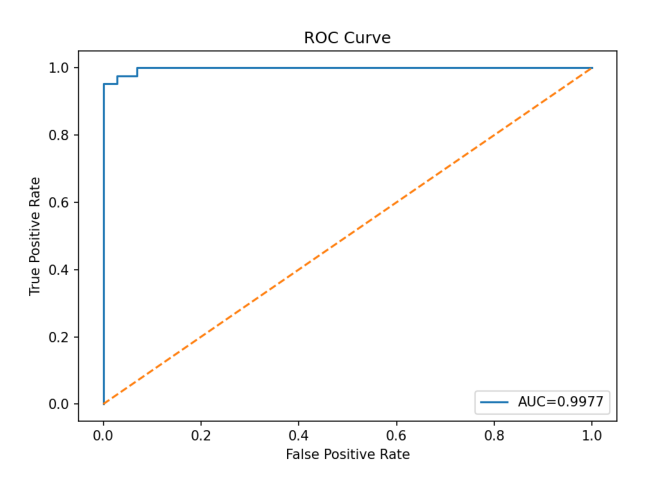

In [9]:
%matplotlib inline 
img_path = "/kaggle/working/roc_curve.png"  
img = plt.imread(img_path)

plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img)
plt.axis("off")  
plt.show()

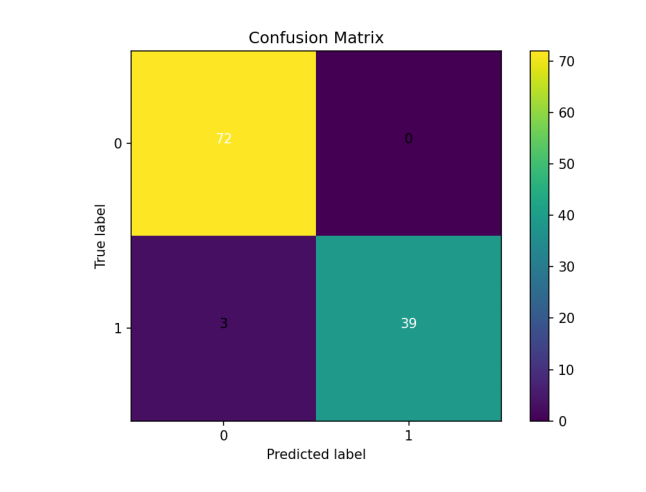

In [10]:
img_path = "/kaggle/working/confusion_matrix.png"  
img = plt.imread(img_path)

plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img)
plt.axis("off")  
plt.show()